## 1. Import

In [1]:
import pandas as pd
import numpy as np

import re
import string
from urllib.parse import urlparse
import tldextract

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

import warnings
warnings.filterwarnings(action='ignore')

## 2. Data Load

In [2]:
# 학습/평가 데이터 로드
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# '[.]'을 '.'으로 복구
train_df['URL'] = train_df['URL'].str.replace(r'\[\.\]', '.', regex=True)
test_df['URL'] = test_df['URL'].str.replace(r'\[\.\]', '.', regex=True)

In [3]:
train_df.isnull().sum()

ID       0
URL      0
label    0
dtype: int64

In [4]:
train_df['label'].value_counts()

label
0    5430159
1    1564897
Name: count, dtype: int64

## 3. Feature-Engineering (FE)

In [5]:
## 새로운 변수 생성
# URL 길이
train_df['length'] = train_df['URL'].str.len()
test_df['length'] = test_df['URL'].str.len()

# 서브도메인 개수
train_df['subdomain_count'] = train_df['URL'].apply(lambda x: len(tldextract.extract(x).subdomain.split('.')) if tldextract.extract(x).subdomain else 0)
test_df['subdomain_count'] = test_df['URL'].apply(lambda x: len(tldextract.extract(x).subdomain.split('.')) if tldextract.extract(x).subdomain else 0)

# 특수 문자 개수
train_df['special_char_count'] = train_df['URL'].apply(lambda x: sum(1 for c in x if c in string.punctuation))
test_df['special_char_count'] = test_df['URL'].apply(lambda x: sum(1 for c in x if c in string.punctuation))

train_df.head()

,ID,URL,label,length,subdomain_count,special_char_count
0,TRAIN_0000000,poznan.wuoz.gov.pl,0,18,0,3
1,TRAIN_0000001,vill.okawa.kochi.jp,0,19,0,3
2,TRAIN_0000002,nationalfinance.co.om,0,21,0,2
3,TRAIN_0000003,town.ozora.hokkaido.jp,0,22,0,3
4,TRAIN_0000004,open24.ie-news.irish/online/Login,1,33,1,5


In [6]:
# 문자 개수
# def count_letters(url):
#     num_letters = sum(char.isalpha() for char in url)
#     return num_letters


# 숫자 개수
def count_digits(url):
    num_digits = sum(char.isdigit() for char in url)
    return num_digits


# train_df["num_letters"] = train_df["URL"].apply(count_letters)
# test_df["num_letters"] = test_df["URL"].apply(count_letters)
train_df["num_digits"] = train_df["URL"].apply(count_digits)
test_df["num_digits"] = test_df["URL"].apply(count_digits)

train_df.head()

,ID,URL,label,length,subdomain_count,special_char_count,num_digits
0,TRAIN_0000000,poznan.wuoz.gov.pl,0,18,0,3,0
1,TRAIN_0000001,vill.okawa.kochi.jp,0,19,0,3,0
2,TRAIN_0000002,nationalfinance.co.om,0,21,0,2,0
3,TRAIN_0000003,town.ozora.hokkaido.jp,0,22,0,3,0
4,TRAIN_0000004,open24.ie-news.irish/online/Login,1,33,1,5,2


In [7]:
# # 짧은 링크인지 여부
# def has_shortening_service(url):
#     pattern = re.compile(r'(?:\w+\.)*(\w+)\.\w+')
#     match = pattern.search(url)
    
#     if match:
#         domain = match.group(1)
#         common_shortening_services = ['bit', 'goo', 'tinyurl', 'ow', 't', 'is',
#                                       'cli', 'yfrog', 'migre', 'ff', 'url4', 'twit',
#                                       'su', 'snipurl', 'short', 'BudURL', 'ping', 
#                                       'post', 'Just', 'bkite', 'snipr', 'fic', 
#                                       'loopt', 'doiop', 'kl', 'wp', 
#                                       'rubyurl', 'om', 'to', 'lnkd', 
#                                       'db', 'adf', 'bitly', 'cur', 'ity', 'q', 
#                                       'po', 'bc', 'twitthis', 'j', 'buzurl', 
#                                       'cutt', 'u', 'yourls', 'x', 'prettylinkpro', 
#                                       'scrnch', 'filoops', 'vzturl', 'qr', '1url', 
#                                       'tweez', 'v', 'tr', 'link', 'zip']
        
#         if domain.lower() in common_shortening_services:
#             return 1
#     return 0

# train_df["shortened"] = train_df["URL"].apply(has_shortening_service)
# test_df["shortened"] = test_df["URL"].apply(has_shortening_service)

# train_df.head()

In [8]:
# # URL에 https 포함 여부
# def include_https(url):
#     if "https" in url:
#         return 1
#     return 0

# train_df["https"] = train_df["URL"].apply(include_https)
# test_df["https"] = test_df["URL"].apply(include_https)

# train_df.head()

In [9]:
# 대문자 포함 여부
def include_uppercase(url):
    if pd.isna(url):
        return 0
    return 1 if any(c.isupper() for c in str(url)) else 0

train_df["uppercase"] = train_df["URL"].apply(include_uppercase)
test_df["uppercase"] = test_df["URL"].apply(include_uppercase)

train_df.head()

,ID,URL,label,length,subdomain_count,special_char_count,num_digits,uppercase
0,TRAIN_0000000,poznan.wuoz.gov.pl,0,18,0,3,0,0
1,TRAIN_0000001,vill.okawa.kochi.jp,0,19,0,3,0,0
2,TRAIN_0000002,nationalfinance.co.om,0,21,0,2,0,0
3,TRAIN_0000003,town.ozora.hokkaido.jp,0,22,0,3,0,0
4,TRAIN_0000004,open24.ie-news.irish/online/Login,1,33,1,5,2,1


In [10]:
# # URL에 IP 주소 포함 여부
# def include_ip_address(url):
#     pattern = re.compile(r'\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}')
#     match = pattern.search(url)
    
#     if match:
#         return 1
#     return 0

# train_df["ip_address"] = train_df["URL"].apply(include_ip_address)
# test_df["ip_address"] = test_df["URL"].apply(include_ip_address)

# train_df.head()

In [11]:
# # 파일확장자 포함 여부
# def check_extension(url):
#     extensions = [
#         ".php",
#         ".html",
#         ".htm",
#         ".hwp",
#         ".hwpx",
#         ".pptx",
#         ".docx",
#         ".iso",
#         ".js",
#         ".lnk",
#         ".vbs",
#         ".xls",
#         ".xml",
#         ".zip",
#         ".xlsx",
#     ]
#     for ext in extensions:
#         if ext in url:
#             return 1
#     return 0


# train_df["extension_check"] = train_df["URL"].apply(lambda url: check_extension(url))
# test_df["extension_check"] = test_df["URL"].apply(lambda url: check_extension(url))

# train_df.head()

In [12]:
# URL 무작위성
import math
from collections import Counter


def calculate_entropy(url):
    # 문자 빈도수 계산
    counter = Counter(url)
    length = len(url)

    # 섀넌 엔트로피 계산
    entropy = 0
    for count in counter.values():
        probability = count / length
        entropy -= probability * math.log2(probability)
    return entropy


def check_randomness(url):
    # 1. 엔트로피 계산
    entropy = calculate_entropy(url)

    # 2. 연속된 숫자나 문자의 최대 길이
    max_consecutive = 1
    current_consecutive = 1
    for i in range(1, len(url)):
        if (
            url[i].isalnum()
            and url[i - 1].isalnum()
            and url[i].lower() == url[i - 1].lower()
        ):
            current_consecutive += 1
            max_consecutive = max(max_consecutive, current_consecutive)
        else:
            current_consecutive = 1

    # 3. 숫자와 문자의 교차 패턴 수
    transitions = 0
    for i in range(1, len(url)):
        if (url[i - 1].isdigit() and url[i].isalpha()) or (
            url[i - 1].isalpha() and url[i].isdigit()
        ):
            transitions += 1

    # 무작위성 점수 계산 (0~1 사이로 정규화)
    entropy_score = min(entropy / 5.0, 1.0)  # 일반적인 URL의 최대 엔트로피를 5로 가정
    consecutive_score = min(
        max_consecutive / 10.0, 1.0
    )  # 연속된 문자가 많을수록 낮은 점수
    transition_score = min(transitions / 10.0, 1.0)  # 전환이 많을수록 높은 점수

    # 종합 점수 계산 (가중치 조정 가능)
    randomness_score = (
        entropy_score * 0.5 + (1 - consecutive_score) * 0.3 + transition_score * 0.2
    )

    return randomness_score


# 데이터프레임에 적용
train_df["randomness"] = train_df["URL"].apply(check_randomness)
test_df["randomness"] = test_df["URL"].apply(check_randomness)

train_df.head()

,ID,URL,label,length,subdomain_count,special_char_count,num_digits,uppercase,randomness
0,TRAIN_0000000,poznan.wuoz.gov.pl,0,18,0,3,0,0,0.600827
1,TRAIN_0000001,vill.okawa.kochi.jp,0,19,0,3,0,0,0.587135
2,TRAIN_0000002,nationalfinance.co.om,0,21,0,2,0,0,0.597280
3,TRAIN_0000003,town.ozora.hokkaido.jp,0,22,0,3,0,0,0.593377
4,TRAIN_0000004,open24.ie-news.irish/online/Login,1,33,1,5,2,1,0.667245


In [13]:
# 타이포스쿼팅 구분
def check_typosquatting(url):
    # 자주 사용되는 브랜드/도메인 목록
    common_brands = {
        "google",
        "facebook",
        "amazon",
        "microsoft",
        "apple",
        "netflix",
        "paypal",
        "twitter",
        "instagram",
        "linkedin",
        "youtube",
        "yahoo",
        "gmail",
        "whatsapp",
        "tiktok",
        "geocities",
        "angelfire",
        "newadvent",
        "wikipedia",
    }

    # 타이포스쿼팅 패턴 점수
    score = 0

    try:
        # URL 파싱
        parsed = urlparse(url if "//" in url else "//" + url)
        domain = parsed.netloc.lower() if parsed.netloc else url.lower()

        # 1. 숫자로 문자 대체 패턴 (예: o -> 0, i -> 1, e -> 3)
        number_substitutions = sum(1 for c in domain if c.isdigit())
        if number_substitutions > 0:
            score += 0.2

        # 2. 유사 브랜드 확인
        for brand in common_brands:
            # 레벤슈타인 거리 계산 (문자열 간 편집 거리)
            if brand not in domain:
                similar = False
                # 비슷한 철자 패턴 확인
                patterns = [
                    brand.replace("o", "0"),
                    brand.replace("i", "1"),
                    brand.replace("l", "1"),
                    brand.replace("e", "3"),
                    brand.replace("a", "4"),
                    brand.replace("s", "5"),
                    brand + "-",
                    brand + "_",
                    brand[:-1],  # 마지막 문자 제거
                    "".join(c + c for c in brand),  # 문자 중복
                ]

                for pattern in patterns:
                    if pattern in domain:
                        similar = True
                        break

                if similar:
                    score += 0.3
                    break

        # 3. 반복되는 문자 패턴
        repeated_chars = re.findall(r"(.)\1{2,}", domain)
        if repeated_chars:
            score += 0.2

        # 4. 특수문자 사용
        special_chars = re.findall(r"[-_.]", domain)
        if len(special_chars) > 2:  # 도메인에 특수문자가 많이 사용된 경우
            score += 0.2

        # 5. 도메인 길이 확인
        if len(domain) > 30:  # 비정상적으로 긴 도메인
            score += 0.1

    except:
        return 0

    return min(score, 1.0)  # 최대 점수는 1.0


# 데이터프레임에 적용
train_df["typosquatting"] = train_df["URL"].apply(check_typosquatting)
test_df["typosquatting"] = test_df["URL"].apply(check_typosquatting)

train_df.head()

,ID,URL,label,length,subdomain_count,special_char_count,num_digits,uppercase,randomness,typosquatting
0,TRAIN_0000000,poznan.wuoz.gov.pl,0,18,0,3,0,0,0.600827,0.2
1,TRAIN_0000001,vill.okawa.kochi.jp,0,19,0,3,0,0,0.587135,0.2
2,TRAIN_0000002,nationalfinance.co.om,0,21,0,2,0,0,0.597280,0.0
3,TRAIN_0000003,town.ozora.hokkaido.jp,0,22,0,3,0,0,0.593377,0.2
4,TRAIN_0000004,open24.ie-news.irish/online/Login,1,33,1,5,2,1,0.667245,0.4


In [14]:
# 피싱 키워드 포함 여부
def include_fishing_keyword(url):
    keywords = [
        "signin", "login", "account", "update", "reset", "urgent", "alert", 
        "security", "support", "banking", "secure", "verify", "password",
        "payment", "customer", "service", "confirm", "approve", "activate",
        "activation", "member", "center", "info", "identity", "register",
        "validation", "authenticate", "recovery", "unblock", "resolution",
        "unlock", "verification", "bank", "transfer", "card",
        "free", "event", "prize"
    ]
    
    url_lower = url.lower()
    for keyword in keywords:
        if keyword in url_lower:
            return 1
    return 0

train_df["fishing_keyword"] = train_df["URL"].apply(include_fishing_keyword)
test_df["fishing_keyword"] = test_df["URL"].apply(include_fishing_keyword)

train_df.head()

,ID,URL,label,length,subdomain_count,special_char_count,num_digits,uppercase,randomness,typosquatting,fishing_keyword
0,TRAIN_0000000,poznan.wuoz.gov.pl,0,18,0,3,0,0,0.600827,0.2,0
1,TRAIN_0000001,vill.okawa.kochi.jp,0,19,0,3,0,0,0.587135,0.2,0
2,TRAIN_0000002,nationalfinance.co.om,0,21,0,2,0,0,0.597280,0.0,0
3,TRAIN_0000003,town.ozora.hokkaido.jp,0,22,0,3,0,0,0.593377,0.2,0
4,TRAIN_0000004,open24.ie-news.irish/online/Login,1,33,1,5,2,1,0.667245,0.4,1


In [15]:
# URL 구성 요소 파싱
def parse_url_components(url):
    try:
        parsed = urlparse(url if "//" in url else "//" + url)
        domain = parsed.netloc
        extracted = tldextract.extract(domain)
        
        components = {
            'domain': domain,
            'path': parsed.path,
            'params': parsed.params,
            'query': parsed.query,
            'fragment': parsed.fragment,
            'tld': extracted.suffix,
            'sld': extracted.domain,
            'subdomain': extracted.subdomain
        }
        
        return components
        
    except:
        return {
            'domain': '', 'path': '', 'params': '',
            'query': '', 'fragment': '', 'tld': '',
            'sld': '', 'subdomain': ''
        }

for df in [train_df, test_df]:
    components = df['URL'].apply(parse_url_components)
    
    df['url_path'] = components.apply(lambda x: x['path'])
    # df['url_params'] = components.apply(lambda x: x['params'])
    # df['url_query'] = components.apply(lambda x: x['query'])
    # df['url_fragment'] = components.apply(lambda x: x['fragment'])
    df['url_tld'] = components.apply(lambda x: x['tld'])
    df['url_sld'] = components.apply(lambda x: x['sld'])
    df['url_subdomain'] = components.apply(lambda x: x['subdomain'])

train_df.head()

,ID,URL,label,length,subdomain_count,special_char_count,num_digits,uppercase,randomness,typosquatting,fishing_keyword,url_path,url_tld,url_sld,url_subdomain
0,TRAIN_0000000,poznan.wuoz.gov.pl,0,18,0,3,0,0,0.600827,0.2,0,,wuoz.gov.pl,poznan,
1,TRAIN_0000001,vill.okawa.kochi.jp,0,19,0,3,0,0,0.587135,0.2,0,,okawa.kochi.jp,vill,
2,TRAIN_0000002,nationalfinance.co.om,0,21,0,2,0,0,0.597280,0.0,0,,co.om,nationalfinance,
3,TRAIN_0000003,town.ozora.hokkaido.jp,0,22,0,3,0,0,0.593377,0.2,0,,ozora.hokkaido.jp,town,
4,TRAIN_0000004,open24.ie-news.irish/online/Login,1,33,1,5,2,1,0.667245,0.4,1,/online/Login,irish,ie-news,open24


In [16]:
# URL 구성 요소들의 길이
train_df['url_path_length'] = train_df['url_path'].str.len()
train_df['url_tld_length'] = train_df['url_tld'].str.len()
train_df['url_sld_length'] = train_df['url_sld'].str.len()
train_df['url_subdomain_length'] = train_df['url_subdomain'].str.len()

test_df['url_path_length'] = test_df['url_path'].str.len()
test_df['url_tld_length'] = test_df['url_tld'].str.len()
test_df['url_sld_length'] = test_df['url_sld'].str.len()
test_df['url_subdomain_length'] = test_df['url_subdomain'].str.len()

train_df.head()

,ID,URL,label,length,subdomain_count,special_char_count,num_digits,uppercase,randomness,typosquatting,fishing_keyword,url_path,url_tld,url_sld,url_subdomain,url_path_length,url_tld_length,url_sld_length,url_subdomain_length
0,TRAIN_0000000,poznan.wuoz.gov.pl,0,18,0,3,0,0,0.600827,0.2,0,,wuoz.gov.pl,poznan,,0,11,6,0
1,TRAIN_0000001,vill.okawa.kochi.jp,0,19,0,3,0,0,0.587135,0.2,0,,okawa.kochi.jp,vill,,0,14,4,0
2,TRAIN_0000002,nationalfinance.co.om,0,21,0,2,0,0,0.597280,0.0,0,,co.om,nationalfinance,,0,5,15,0
3,TRAIN_0000003,town.ozora.hokkaido.jp,0,22,0,3,0,0,0.593377,0.2,0,,ozora.hokkaido.jp,town,,0,17,4,0
4,TRAIN_0000004,open24.ie-news.irish/online/Login,1,33,1,5,2,1,0.667245,0.4,1,/online/Login,irish,ie-news,open24,13,5,7,6


In [17]:
# URL 구성 요소들의 특수문자 개수
train_df['url_path_special_chars'] = train_df['url_path'].apply(lambda x: sum(1 for c in x if c in string.punctuation))
train_df['url_tld_special_chars'] = train_df['url_tld'].apply(lambda x: sum(1 for c in x if c in string.punctuation))
train_df['url_sld_special_chars'] = train_df['url_sld'].apply(lambda x: sum(1 for c in x if c in string.punctuation))
train_df['url_subdomain_special_chars'] = train_df['url_subdomain'].apply(lambda x: sum(1 for c in x if c in string.punctuation))

test_df['url_path_special_chars'] = test_df['url_path'].apply(lambda x: sum(1 for c in x if c in string.punctuation))
test_df['url_tld_special_chars'] = test_df['url_tld'].apply(lambda x: sum(1 for c in x if c in string.punctuation))
test_df['url_sld_special_chars'] = test_df['url_sld'].apply(lambda x: sum(1 for c in x if c in string.punctuation))
test_df['url_subdomain_special_chars'] = test_df['url_subdomain'].apply(lambda x: sum(1 for c in x if c in string.punctuation))

train_df.head()

,ID,URL,label,length,subdomain_count,special_char_count,num_digits,uppercase,randomness,typosquatting,...,url_sld,url_subdomain,url_path_length,url_tld_length,url_sld_length,url_subdomain_length,url_path_special_chars,url_tld_special_chars,url_sld_special_chars,url_subdomain_special_chars
0,TRAIN_0000000,poznan.wuoz.gov.pl,0,18,0,3,0,0,0.600827,0.2,...,poznan,,0,11,6,0,0,2,0,0
1,TRAIN_0000001,vill.okawa.kochi.jp,0,19,0,3,0,0,0.587135,0.2,...,vill,,0,14,4,0,0,2,0,0
2,TRAIN_0000002,nationalfinance.co.om,0,21,0,2,0,0,0.597280,0.0,...,nationalfinance,,0,5,15,0,0,1,0,0
3,TRAIN_0000003,town.ozora.hokkaido.jp,0,22,0,3,0,0,0.593377,0.2,...,town,,0,17,4,0,0,2,0,0
4,TRAIN_0000004,open24.ie-news.irish/online/Login,1,33,1,5,2,1,0.667245,0.4,...,ie-news,open24,13,5,7,6,2,0,1,0


In [18]:
# # URL 구성 요소별 대문자 포함 여부
# train_df['url_path_uppercase'] = train_df['url_path'].apply(include_uppercase)
# train_df['url_tld_uppercase'] = train_df['url_tld'].apply(include_uppercase)
# train_df['url_sld_uppercase'] = train_df['url_sld'].apply(include_uppercase)
# train_df['url_subdomain_uppercase'] = train_df['url_subdomain'].apply(include_uppercase)

# test_df['url_path_uppercase'] = test_df['url_path'].apply(include_uppercase)
# test_df['url_tld_uppercase'] = test_df['url_tld'].apply(include_uppercase)
# test_df['url_sld_uppercase'] = test_df['url_sld'].apply(include_uppercase)
# test_df['url_subdomain_uppercase'] = test_df['url_subdomain'].apply(include_uppercase)

# train_df.head()

,ID,URL,label,length,subdomain_count,special_char_count,num_digits,uppercase,randomness,typosquatting,...,url_sld_length,url_subdomain_length,url_path_special_chars,url_tld_special_chars,url_sld_special_chars,url_subdomain_special_chars,url_path_uppercase,url_tld_uppercase,url_sld_uppercase,url_subdomain_uppercase
0,TRAIN_0000000,poznan.wuoz.gov.pl,0,18,0,3,0,0,0.600827,0.2,...,6,0,0,2,0,0,0,0,0,0
1,TRAIN_0000001,vill.okawa.kochi.jp,0,19,0,3,0,0,0.587135,0.2,...,4,0,0,2,0,0,0,0,0,0
2,TRAIN_0000002,nationalfinance.co.om,0,21,0,2,0,0,0.597280,0.0,...,15,0,0,1,0,0,0,0,0,0
3,TRAIN_0000003,town.ozora.hokkaido.jp,0,22,0,3,0,0,0.593377,0.2,...,4,0,0,2,0,0,0,0,0,0
4,TRAIN_0000004,open24.ie-news.irish/online/Login,1,33,1,5,2,1,0.667245,0.4,...,7,6,2,0,1,0,1,0,0,0


In [19]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)

train_df['tld_phishing_ratio_cv'] = 0
train_df['sld_phishing_ratio_cv'] = 0

for train_idx, val_idx in kf.split(train_df):
    X_train, X_val = train_df.iloc[train_idx], train_df.iloc[val_idx]

    # tld 기준
    pivot_tld = X_train.groupby('url_tld')['label'].mean()
    train_df.loc[val_idx, 'tld_phishing_ratio_cv'] = train_df.loc[val_idx, 'url_tld'].map(pivot_tld)

    # sld 기준
    pivot_sld = X_train.groupby('url_sld')['label'].mean()
    train_df.loc[val_idx, 'sld_phishing_ratio_cv'] = train_df.loc[val_idx, 'url_sld'].map(pivot_sld)

# 결측치는 global 평균으로 채움
train_df['tld_phishing_ratio_cv'].fillna(train_df['label'].mean(), inplace=True)
train_df['sld_phishing_ratio_cv'].fillna(train_df['label'].mean(), inplace=True)

# test_df는 전체 train 기준으로 만든 피벗으로 적용
pivot_tld_full = train_df.groupby('url_tld')['label'].mean()
pivot_sld_full = train_df.groupby('url_sld')['label'].mean()

test_df['tld_phishing_ratio_cv'] = test_df['url_tld'].map(pivot_tld_full)
test_df['sld_phishing_ratio_cv'] = test_df['url_sld'].map(pivot_sld_full)

test_df['tld_phishing_ratio_cv'].fillna(train_df['label'].mean(), inplace=True)
test_df['sld_phishing_ratio_cv'].fillna(train_df['label'].mean(), inplace=True)

# 새 피처 초기화
for col in ['sld_phishing_ratio_cv', 'sld_mean_special_char_cv', 'keyword_mean_randomness_cv', 'subdomain_phishing_ratio_cv']:
    train_df[col] = 0

# 교차 검증으로 피처 생성 (리키지 방지)
for train_idx, val_idx in kf.split(train_df):
    X_train, X_val = train_df.iloc[train_idx], train_df.iloc[val_idx]

    # url_sld별 피싱 비율, 특수문자 평균
    pivot_sld = X_train.groupby('url_sld').agg({'label':'mean', 'special_char_count':'mean'})
    train_df.loc[val_idx, 'sld_phishing_ratio_cv'] = train_df.loc[val_idx, 'url_sld'].map(pivot_sld['label'])
    train_df.loc[val_idx, 'sld_mean_special_char_cv'] = train_df.loc[val_idx, 'url_sld'].map(pivot_sld['special_char_count'])

    # fishing_keyword별 평균 randomness
    pivot_keyword = X_train.groupby('fishing_keyword')['randomness'].mean()
    train_df.loc[val_idx, 'keyword_mean_randomness_cv'] = train_df.loc[val_idx, 'fishing_keyword'].map(pivot_keyword)

    # subdomain_count별 피싱 비율
    pivot_subdomain = X_train.groupby('subdomain_count')['label'].mean()
    train_df.loc[val_idx, 'subdomain_phishing_ratio_cv'] = train_df.loc[val_idx, 'subdomain_count'].map(pivot_subdomain)

# 결측치 처리
train_df['sld_phishing_ratio_cv'].fillna(train_df['label'].mean(), inplace=True)
train_df['sld_mean_special_char_cv'].fillna(train_df['special_char_count'].mean(), inplace=True)
train_df['keyword_mean_randomness_cv'].fillna(train_df['randomness'].mean(), inplace=True)
train_df['subdomain_phishing_ratio_cv'].fillna(train_df['label'].mean(), inplace=True)

# test_df에 적용
pivot_sld_full = train_df.groupby('url_sld').agg({'label':'mean', 'special_char_count':'mean'})
pivot_keyword_full = train_df.groupby('fishing_keyword')['randomness'].mean()
pivot_subdomain_full = train_df.groupby('subdomain_count')['label'].mean()

test_df['sld_phishing_ratio_cv'] = test_df['url_sld'].map(pivot_sld_full['label'])
test_df['sld_mean_special_char_cv'] = test_df['url_sld'].map(pivot_sld_full['special_char_count'])
test_df['keyword_mean_randomness_cv'] = test_df['fishing_keyword'].map(pivot_keyword_full)
test_df['subdomain_phishing_ratio_cv'] = test_df['subdomain_count'].map(pivot_subdomain_full)

# 결측치 처리 (test)
test_df['sld_phishing_ratio_cv'].fillna(train_df['label'].mean(), inplace=True)
test_df['sld_mean_special_char_cv'].fillna(train_df['special_char_count'].mean(), inplace=True)
test_df['keyword_mean_randomness_cv'].fillna(train_df['randomness'].mean(), inplace=True)
test_df['subdomain_phishing_ratio_cv'].fillna(train_df['label'].mean(), inplace=True)

# 전체 train 데이터의 피싱 비율 (전체 평균)
global_mean = train_df['label'].mean()

# 교차 검증을 사용해 url_subdomain별 피싱 비율 피처 만들기
train_df['subdomain_phishing_ratio_cv'] = 0
for train_idx, val_idx in kf.split(train_df):
    X_train = train_df.iloc[train_idx]
    pivot_subdomain = X_train.groupby('url_subdomain')['label'].mean()
    train_df.loc[val_idx, 'subdomain_phishing_ratio_cv'] = train_df.loc[val_idx, 'url_subdomain'].map(pivot_subdomain)
train_df['subdomain_phishing_ratio_cv'].fillna(global_mean, inplace=True)

# test_df에도 같은 피처 적용
pivot_subdomain_full = train_df.groupby('url_subdomain')['label'].mean()
test_df['subdomain_phishing_ratio_cv'] = test_df['url_subdomain'].map(pivot_subdomain_full)
test_df['subdomain_phishing_ratio_cv'].fillna(global_mean, inplace=True)

train_df.head()

,ID,URL,label,length,subdomain_count,special_char_count,num_digits,uppercase,randomness,typosquatting,...,url_subdomain_special_chars,url_path_uppercase,url_tld_uppercase,url_sld_uppercase,url_subdomain_uppercase,tld_phishing_ratio_cv,sld_phishing_ratio_cv,sld_mean_special_char_cv,keyword_mean_randomness_cv,subdomain_phishing_ratio_cv
0,TRAIN_0000000,poznan.wuoz.gov.pl,0,18,0,3,0,0,0.600827,0.2,...,0,0,0,0,0,0.000000,0.027174,2.750000,0.615153,0.146982
1,TRAIN_0000001,vill.okawa.kochi.jp,0,19,0,3,0,0,0.587135,0.2,...,0,0,0,0,0,0.223715,0.000000,3.039604,0.615146,0.146930
2,TRAIN_0000002,nationalfinance.co.om,0,21,0,2,0,0,0.597280,0.0,...,0,0,0,0,0,0.142857,0.000000,2.000000,0.615153,0.146982
3,TRAIN_0000003,town.ozora.hokkaido.jp,0,22,0,3,0,0,0.593377,0.2,...,0,0,0,0,0,0.000000,0.000000,3.133333,0.615143,0.146863
4,TRAIN_0000004,open24.ie-news.irish/online/Login,1,33,1,5,2,1,0.667245,0.4,...,0,1,0,0,0,0.300000,1.000000,3.000000,0.683581,1.000000


In [71]:
train_df.to_csv('train_features.csv', index=False)
test_df.to_csv('test_features.csv', index=False)

### EDA 

In [27]:
train_df = pd.read_csv('train_features.csv')
test_df = pd.read_csv('test_features.csv')

In [37]:
# variables = ['length', 'subdomain_count', 'special_char_count', 'num_digits', 'randomness', 'typosquatting', 'url_path_length', 'url_tld_length', 'url_sld_length', 'url_subdomain_length', 'url_path_special_chars', 'url_tld_special_chars', 'url_sld_special_chars', 'url_subdomain_special_chars']

# for var in variables:
#     plt.figure(figsize=(8, 5))
#     sns.boxplot(data=train_df, x='label', y=var)
#     plt.title(f"Boxplot of {var} by is_malicious")
#     plt.xlabel("is_malicious")
#     plt.ylabel(var)
#     plt.xticks([0, 1], ['Non-Malicious', 'Malicious'])
#     plt.show()

In [32]:
# variables = ['uppercase']

# for var in variables:
#     plt.figure(figsize=(6.4, 4.8))
#     ax = sns.countplot(data=train_df, x=var, hue='label')

#     for p in ax.patches:
#         ax.annotate(f'{int(p.get_height())}', 
#                     (p.get_x() + p.get_width()/2., p.get_height()),
#                     ha='center', va='bottom')

#     plt.title(f'Distribution of {var} URLs by Label')
#     plt.xlabel(f'Is {var} URL')
#     plt.ylabel('Count')
#     plt.legend(labels=['Non-Malicious', 'Malicious'])
#     plt.show()

- URL 길이 길수록 악성 URL 가능성 높음
- 서브도메인 수 많을수록 악성 URL 가능성 높음
- 특수문자 많이 포함할수록 악성 URL 가능성 높음
- 숫자 많이 포함할수록 악성 URL 가능성 높음(문자도 동일)
- 짧은 링크일 경우 악성 URL 가능성 높음
- https가 프로토콜로서 사용되지 않는 경우 악성 URL 가능성 높음
- 대문자 포함 시 악성 URL 가능성 높음

### 상관 관계 분석

In [ ]:
correlation_matrix = train_df.corr(numeric_only=True)

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

-  EDA 결과에 따른 가설 설정 

    1. URL의 길이가 길수록 악성 URL일 확률이 높을 것이다. -> 악성 URL은 난독화와 탐지 회피를 위해 길이가 긴 경우가 많다.
    2. 서브도메인이 많을수록 악성 URL일 확률이 높을 것이다. -> 서브도메인은 피싱과 사용자 혼란을 유발하는 데 자주 활용된다.
    3. 특수문자가 많을수록 악성 URL일 확률이 높을 것이다. -> 특수문자는 난독화와 위장 목적으로 사용된다.


## 4. Pre-processing (전처리)

In [24]:
train_df = pd.read_csv('train_features.csv')
test_df = pd.read_csv('test_features.csv')

In [20]:
train_df.isnull().sum()

ID                             0
URL                            0
label                          0
length                         0
subdomain_count                0
special_char_count             0
num_digits                     0
uppercase                      0
randomness                     0
typosquatting                  0
fishing_keyword                0
url_path                       0
url_tld                        0
url_sld                        0
url_subdomain                  0
url_path_length                0
url_tld_length                 0
url_sld_length                 0
url_subdomain_length           0
url_path_special_chars         0
url_tld_special_chars          0
url_sld_special_chars          0
url_subdomain_special_chars    0
url_path_uppercase             0
url_tld_uppercase              0
url_sld_uppercase              0
url_subdomain_uppercase        0
tld_phishing_ratio_cv          0
sld_phishing_ratio_cv          0
sld_mean_special_char_cv       0
keyword_me

In [21]:
train_df.fillna(0, inplace=True)
test_df.fillna(0, inplace=True)

In [22]:
X = train_df.drop(columns=['ID', 'label', 'URL'])
y = train_df['label']

X_test = test_df.drop(columns=['ID', 'URL'])

In [23]:
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns
scaler = StandardScaler()
X[numeric_cols] = scaler.fit_transform(X[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

## 5. K-Fold Model Training (모델 학습)

In [24]:
kf = KFold(n_splits=4, shuffle=True, random_state=42)
models = []
auc_scores = []

categorical_cols = X.select_dtypes(include="object").columns.tolist()

for idx, (train_idx, val_idx) in enumerate(kf.split(X)):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    print("-" * 40)
    print(f"Fold {idx + 1}")

    model = CatBoostClassifier(
        iterations=150,
        depth=8,
        learning_rate=0.07,
        random_seed=42,
        cat_features=categorical_cols,
        eval_metric="AUC",
        task_type="GPU",
        class_weights=[1, 3],
        verbose=10,
    )

    eval_set = [(X_val, y_val)]
    model.fit(
        X_train,
        y_train,
        eval_set=eval_set,
        early_stopping_rounds=50,
    )

    models.append(model)

    y_val_pred_prob = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_val_pred_prob)
    print(f"Fold {idx + 1} CV ROC-AUC: {auc:.4f}")
    auc_scores.append(auc)

print(f"K-Fold 평균 ROC-AUC: {np.mean(auc_scores):.4f}")

----------------------------------------
Fold 1


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9759702	best: 0.9759702 (0)	total: 165ms	remaining: 24.6s
10:	test: 0.9829761	best: 0.9829761 (10)	total: 1.2s	remaining: 15.1s
20:	test: 0.9841976	best: 0.9841976 (20)	total: 2.25s	remaining: 13.8s
30:	test: 0.9851336	best: 0.9851336 (30)	total: 3.33s	remaining: 12.8s
40:	test: 0.9855789	best: 0.9855789 (40)	total: 4.39s	remaining: 11.7s
50:	test: 0.9858801	best: 0.9858801 (50)	total: 5.46s	remaining: 10.6s
60:	test: 0.9861098	best: 0.9861098 (60)	total: 6.49s	remaining: 9.47s
70:	test: 0.9863037	best: 0.9863037 (70)	total: 7.54s	remaining: 8.39s
80:	test: 0.9864888	best: 0.9864888 (80)	total: 8.61s	remaining: 7.33s
90:	test: 0.9866000	best: 0.9866000 (90)	total: 9.66s	remaining: 6.27s
100:	test: 0.9866796	best: 0.9866796 (100)	total: 10.7s	remaining: 5.19s
110:	test: 0.9867544	best: 0.9867544 (110)	total: 11.7s	remaining: 4.13s
120:	test: 0.9868252	best: 0.9868252 (120)	total: 12.8s	remaining: 3.06s
130:	test: 0.9869173	best: 0.9869173 (130)	total: 13.8s	remaining: 2.01s
1

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9764904	best: 0.9764904 (0)	total: 100ms	remaining: 14.9s
10:	test: 0.9830369	best: 0.9830369 (10)	total: 1.07s	remaining: 13.6s
20:	test: 0.9844321	best: 0.9844321 (20)	total: 2.05s	remaining: 12.6s
30:	test: 0.9857473	best: 0.9857473 (30)	total: 3.04s	remaining: 11.7s
40:	test: 0.9862284	best: 0.9862284 (40)	total: 4.03s	remaining: 10.7s
50:	test: 0.9865313	best: 0.9865313 (50)	total: 5.04s	remaining: 9.78s
60:	test: 0.9867427	best: 0.9867427 (60)	total: 6.04s	remaining: 8.81s
70:	test: 0.9868977	best: 0.9868977 (70)	total: 7.09s	remaining: 7.89s
80:	test: 0.9870860	best: 0.9870860 (80)	total: 8.13s	remaining: 6.92s
90:	test: 0.9872002	best: 0.9872002 (90)	total: 9.15s	remaining: 5.94s
100:	test: 0.9873043	best: 0.9873043 (100)	total: 10.2s	remaining: 4.95s
110:	test: 0.9874157	best: 0.9874157 (110)	total: 11.2s	remaining: 3.94s
120:	test: 0.9875038	best: 0.9875038 (120)	total: 12.3s	remaining: 2.94s
130:	test: 0.9876008	best: 0.9876008 (130)	total: 13.3s	remaining: 1.93s


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9759388	best: 0.9759388 (0)	total: 94.7ms	remaining: 14.1s
10:	test: 0.9827463	best: 0.9827463 (10)	total: 1.01s	remaining: 12.8s
20:	test: 0.9841747	best: 0.9841747 (20)	total: 1.94s	remaining: 11.9s
30:	test: 0.9850541	best: 0.9850541 (30)	total: 2.87s	remaining: 11s
40:	test: 0.9860975	best: 0.9860975 (40)	total: 3.8s	remaining: 10.1s
50:	test: 0.9864007	best: 0.9864007 (50)	total: 4.75s	remaining: 9.22s
60:	test: 0.9866789	best: 0.9866789 (60)	total: 5.69s	remaining: 8.3s
70:	test: 0.9868725	best: 0.9868725 (70)	total: 6.62s	remaining: 7.36s
80:	test: 0.9870192	best: 0.9870192 (80)	total: 7.55s	remaining: 6.43s
90:	test: 0.9871583	best: 0.9871583 (90)	total: 8.5s	remaining: 5.51s
100:	test: 0.9872730	best: 0.9872730 (100)	total: 9.46s	remaining: 4.59s
110:	test: 0.9873466	best: 0.9873466 (110)	total: 10.4s	remaining: 3.66s
120:	test: 0.9874179	best: 0.9874179 (120)	total: 11.4s	remaining: 2.72s
130:	test: 0.9874981	best: 0.9874981 (130)	total: 12.3s	remaining: 1.78s
140:

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9766217	best: 0.9766217 (0)	total: 110ms	remaining: 16.4s
10:	test: 0.9832471	best: 0.9832471 (10)	total: 1.14s	remaining: 14.4s
20:	test: 0.9844626	best: 0.9844626 (20)	total: 2.18s	remaining: 13.4s
30:	test: 0.9853639	best: 0.9853639 (30)	total: 3.21s	remaining: 12.3s
40:	test: 0.9858198	best: 0.9858198 (40)	total: 4.27s	remaining: 11.3s
50:	test: 0.9861382	best: 0.9861382 (50)	total: 5.35s	remaining: 10.4s
60:	test: 0.9863358	best: 0.9863358 (60)	total: 6.42s	remaining: 9.37s
70:	test: 0.9865118	best: 0.9865118 (70)	total: 7.48s	remaining: 8.32s
80:	test: 0.9866677	best: 0.9866677 (80)	total: 8.52s	remaining: 7.26s
90:	test: 0.9868038	best: 0.9868038 (90)	total: 9.58s	remaining: 6.21s
100:	test: 0.9868941	best: 0.9868941 (100)	total: 10.6s	remaining: 5.15s
110:	test: 0.9869831	best: 0.9869831 (110)	total: 11.7s	remaining: 4.1s
120:	test: 0.9870571	best: 0.9870571 (120)	total: 12.7s	remaining: 3.04s
130:	test: 0.9871316	best: 0.9871316 (130)	total: 13.7s	remaining: 1.99s
1

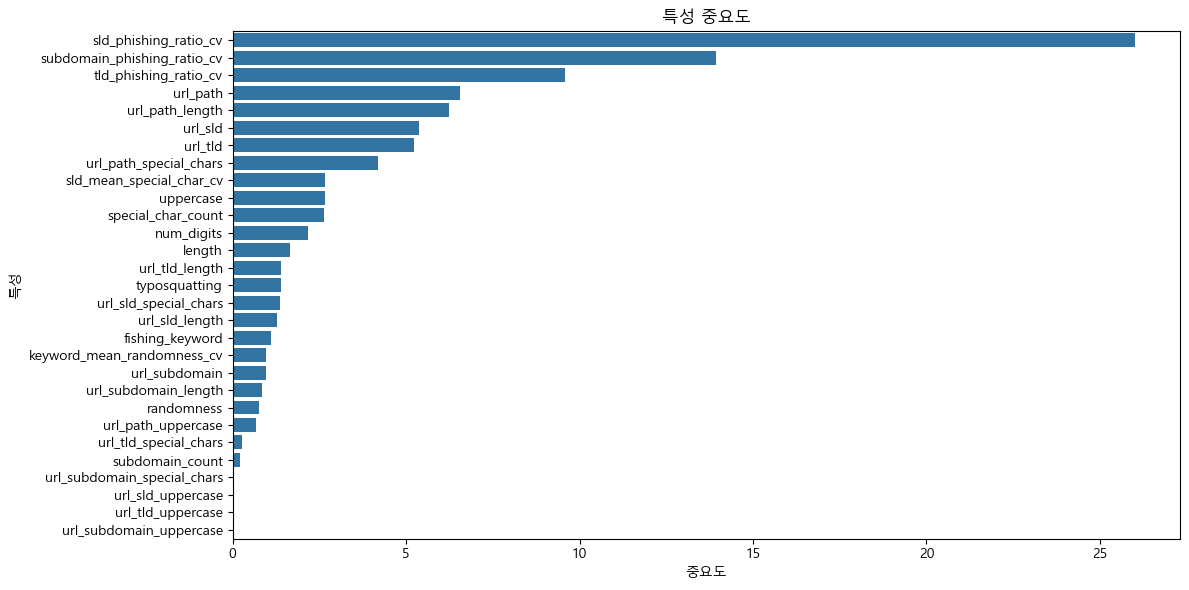

In [25]:
# 특성 중요도 시각화
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': models[0].feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(data=feature_importance, x='importance', y='feature')
plt.title('특성 중요도')
plt.xlabel('중요도')
plt.ylabel('특성')
plt.tight_layout()
plt.show()

## 6. K-Fold Ensemble Inference (K-Fold 앙상블 추론)

In [32]:
test_probabilities = np.zeros(len(X_test))

for model in models:
    test_probabilities += model.predict_proba(X_test)[:, 1]

test_probabilities /= len(models)
print('Inference Done.')

Inference Done.


## 7. Submission (제출 파일 생성)

In [33]:
test_df['probability'] = test_probabilities
test_df[['ID', 'probability']].to_csv('./submission.csv', index=False)
print('Done.')

Done.
